<a href="https://colab.research.google.com/github/mphani/ts_prophet/blob/works/as_prophet_actual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet.plot import plot_plotly, plot_components_plotly

from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric


In [2]:
G_FILENAME = "sample_data/24122023_aerospike_stats.csv"

In [3]:
original_df = pd.read_csv(G_FILENAME)
original_df.head()

cluster_name              instance   ns               service  \
0         numa  192.168.200.239:9145  ssd  192.168.201.239:3000   
1         numa  192.168.200.239:9145  ssd  192.168.201.239:3000   
2         numa  192.168.200.239:9145  ssd  192.168.201.239:3000   
3         numa  192.168.200.239:9145  ssd  192.168.201.239:3000   
4         numa  192.168.200.239:9145  ssd  192.168.201.239:3000   

                               metric_name sub_query_name  \
0  aerospike_namespace_client_read_success     rate_query   
1  aerospike_namespace_client_read_success     rate_query   
2  aerospike_namespace_client_read_success     rate_query   
3  aerospike_namespace_client_read_success     rate_query   
4  aerospike_namespace_client_read_success     rate_query   

                                          prom_query  utc_date_time  \
0  rate(aerospike_namespace_client_read_success[1m])     1703010600   
1  rate(aerospike_namespace_client_read_success[1m])     1703010660   
2  rate(aerospike_namespace_client_read_success[1m])     1703010720   
3  rate(aerospike_namespace_client_read_success[1m])     1703010780   
4  rate(aerospike_namespace_client_read_success[1m])     1703010840   

   metric_value  
0   2882.088889  
1   3006.044444  
2   2960.888889  
3   3010.822222  
4   2992.222222

In [4]:
original_df["date_from_utc"] = pd.to_datetime(original_df.utc_date_time , unit='s')
original_df["full_date"] = original_df["date_from_utc"].dt.date
original_df["year"] = original_df["date_from_utc"].dt.year
original_df["month"] = original_df["date_from_utc"].dt.month
original_df["day"] = original_df["date_from_utc"].dt.day
original_df["hour"] = original_df["date_from_utc"].dt.hour
original_df["minute"] = original_df["date_from_utc"].dt.minute
original_df["second"] = original_df["date_from_utc"].dt.second

In [5]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419622 entries, 0 to 419621
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   cluster_name    419622 non-null  object        
 1   instance        419622 non-null  object        
 2   ns              419622 non-null  object        
 3   service         419622 non-null  object        
 4   metric_name     419622 non-null  object        
 5   sub_query_name  419622 non-null  object        
 6   prom_query      419622 non-null  object        
 7   utc_date_time   419622 non-null  int64         
 8   metric_value    419622 non-null  float64       
 9   date_from_utc   419622 non-null  datetime64[ns]
 10  full_date       419622 non-null  object        
 11  year            419622 non-null  int64         
 12  month           419622 non-null  int64         
 13  day             419622 non-null  int64         
 14  hour            419622 non-null  int

In [6]:
print( original_df.shape)

(419622, 17)


In [8]:
read_df= original_df[ original_df.metric_name=="aerospike_namespace_client_read_success"]
read_df= read_df[ read_df.sub_query_name=="simple_query"]
# pick up only ssd namespace
read_df= read_df[ read_df.ns=="ssd" ]
# read_df= read_df[ (read_df.ns=="ssd") & (read_df.service=="192.168.201.241:3000")]
read_df.shape

(69946, 17)

In [9]:
read_df= read_df[ read_df.service=="192.168.201.241:3000"]
read_df.shape

(23315, 17)

In [ ]:
# read_df= read_df[ (read_df.year==2023) & (read_df.month==12) & ((read_df.day==15) | (read_df.day==5))]
# read_df.shape

In [ ]:
# duplicated_rows_counts = read_df[read_df.duplicated(subset="utc_date_time", keep="first")]
# duplicated_rows_counts.shape

['192.168.201.241:3000']


In [10]:
print(read_df["service"].unique())
print(read_df["ns"].unique())
print(read_df["cluster_name"].unique())
print(read_df["metric_name"].unique())


['192.168.201.241:3000']
['ssd']
['numa']
['aerospike_namespace_client_read_success']


In [14]:
read_df.shape

(23315, 17)

In [ ]:
read_df.head()

In [11]:
# read_df["full_date", "metric_value"].plot()
prophet_read_df = read_df[ ["date_from_utc", "metric_value"] ].copy()
prophet_read_df['date_from_utc'] = pd.to_datetime(prophet_read_df['date_from_utc'], format='%Y-%m-%d %H:%M:%S')

In [22]:
prophet_read_df.rename(columns={"date_from_utc": "ds", "metric_value": "y"}, inplace=True)
prophet_read_df=prophet_read_df.reindex()
prophet_read_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23315 entries, 14400 to 383447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      23315 non-null  datetime64[ns]
 1   y       23315 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 546.4 KB


In [20]:
prophet_read_df.shape

(23315, 2)

In [23]:
l_sort_column_names = ["ds"]
prophet_read_df.sort_values(by= l_sort_column_names, ascending = True)

ds             y
352244 2023-12-07 18:01:00  1.586337e+09
352245 2023-12-07 18:02:00  1.586487e+09
352246 2023-12-07 18:03:00  1.586634e+09
352247 2023-12-07 18:04:00  1.586781e+09
352248 2023-12-07 18:05:00  1.586922e+09
...                    ...           ...
165046 2023-12-24 04:02:00  3.375617e+09
165047 2023-12-24 04:03:00  3.375617e+09
165048 2023-12-24 04:04:00  3.375617e+09
165049 2023-12-24 04:05:00  3.375617e+09
165050 2023-12-24 04:06:00  3.375617e+09

[23315 rows x 2 columns]

In [16]:
# Removing duplicates in the original DataFrame
prophet_read_df.drop_duplicates(subset="ds", inplace=True)


In [25]:
prophet_read_df.plot()

<Axes: >

Error in callback <function _draw_all_if_interactive at 0x7d92344d6200> (for post_execute):


OverflowError: ignored

OverflowError: ignored

<Figure size 640x480 with 1 Axes>

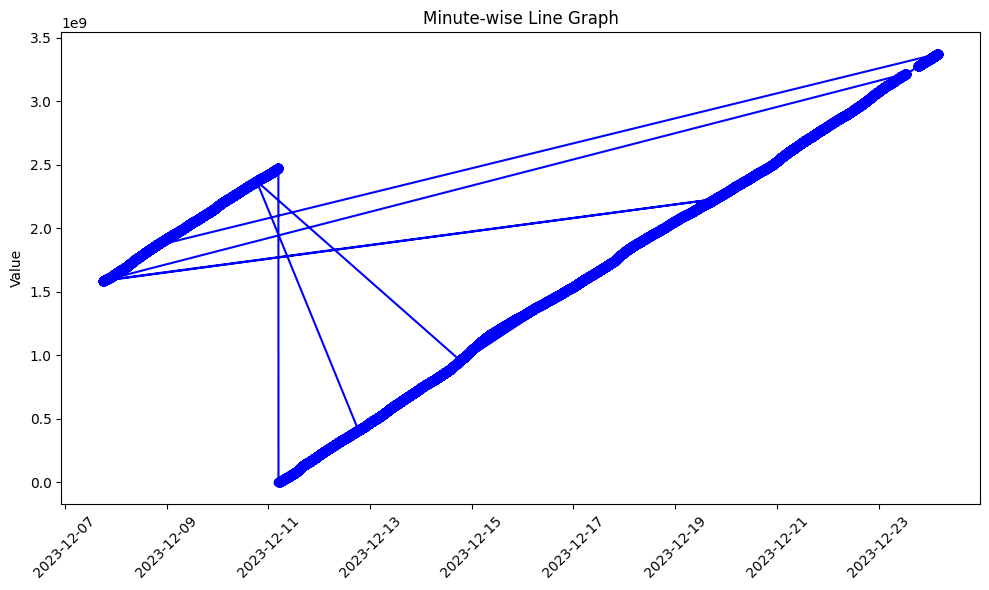

In [26]:
# df['date_from_utc'] = pd.to_datetime(df['date_from_utc'])

# Plotting a line graph
plt.figure(figsize=(10, 6))  # Set figure size as needed

plt.plot(prophet_read_df['ds'], prophet_read_df['y'], color='blue', marker='o', linestyle='-')

# plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Minute-wise Line Graph')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()  # Adjusts plot to fit into the figure area
plt.show()

In [ ]:
# Plotting a line graph
plt.figure(figsize=(10, 6))  # Set figure size as needed

single_day_df = read_df [ read_df.day == 15 ]

single_day_df = single_day_df[ ["date_from_utc", "metric_value"] ].copy()
single_day_df.rename(columns={"date_from_utc": "ds", "metric_value": "y"}, inplace=True)
single_day_df.info()

# plt.plot(single_day_df['ds'], single_day_df['y'], color='green', marker='o', linestyle='--')
plt.bar (single_day_df['ds'], single_day_df['y'], )


plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Minute-wise Line Graph')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()  # Adjusts plot to fit into the figure area
plt.show()

In [28]:
m = Prophet()
# m= Prophet( interval_width=0.9, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True )
m.fit(prophet_read_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9afksb24/kmhbnp4p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9afksb24/qtx3njxe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26397', 'data', 'file=/tmp/tmp9afksb24/kmhbnp4p.json', 'init=/tmp/tmp9afksb24/qtx3njxe.json', 'output', 'file=/tmp/tmp9afksb24/prophet_modeltn2966jh/prophet_model-20231224064458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:44:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:45:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# 1440 = 24 * 60 minutes

#
# future = m.make_future_dataframe(periods= 1440, freq="T", include_history=True)
# future.tail()

ds
24316 2023-12-21 04:02:00
24317 2023-12-21 04:03:00
24318 2023-12-21 04:04:00
24319 2023-12-21 04:05:00
24320 2023-12-21 04:06:00

In [ ]:
# forecast = m.predict(future)
#
# only for anamoly
forecast = m.predict( prophet_read_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds         yhat   yhat_lower   yhat_upper
21892 2023-12-20 16:55:00  2849.454996  2445.700518  3271.347323
21893 2023-12-20 16:56:00  2849.109523  2457.967863  3270.564717
21894 2023-12-20 16:57:00  2848.763051  2429.291221  3259.196594
21895 2023-12-20 16:58:00  2848.415769  2448.390479  3268.761219
21896 2023-12-20 16:59:00  2848.067868  2443.226926  3269.357381

In [ ]:
forecast.info()

In [ ]:
prophet_read_df.info()

<Axes: xlabel='ds'>

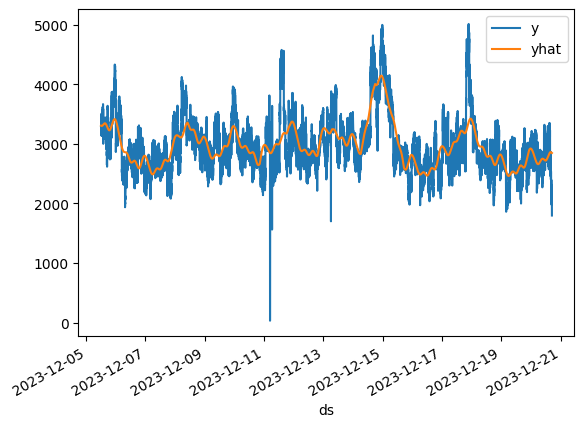

In [ ]:
pd.concat( [prophet_read_df.set_index("ds")["y"],  forecast.set_index("ds")["yhat"]], axis=1).plot()

In [ ]:
# merge original and forecasted
#
merged_df = pd.merge( prophet_read_df, forecast[["ds", "yhat","yhat_lower","yhat_upper"]], on="ds" )

In [ ]:
merged_df.to_csv("prophet_forecasted.csv")

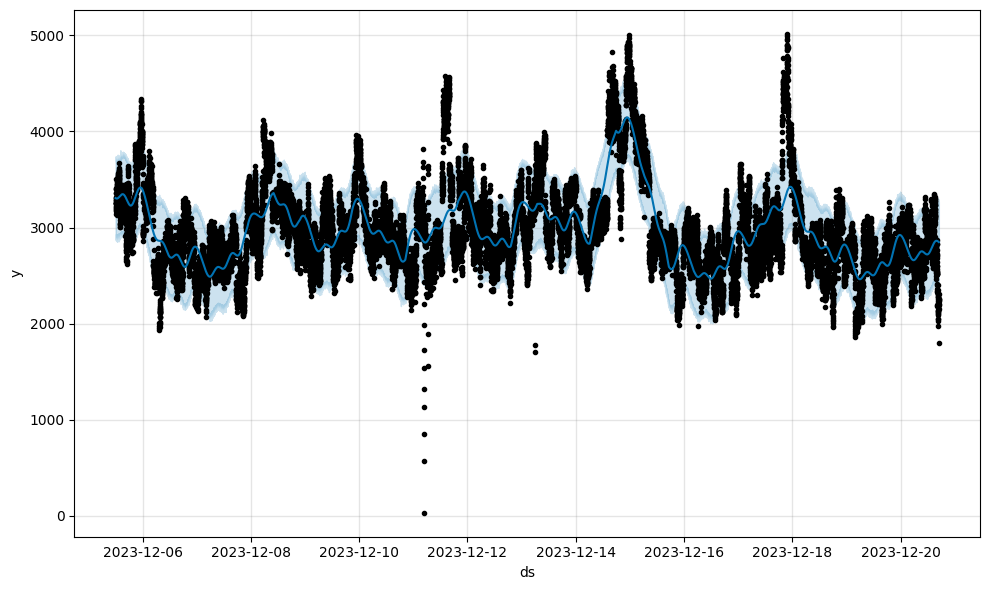

In [ ]:
figure_1 = m.plot(forecast)


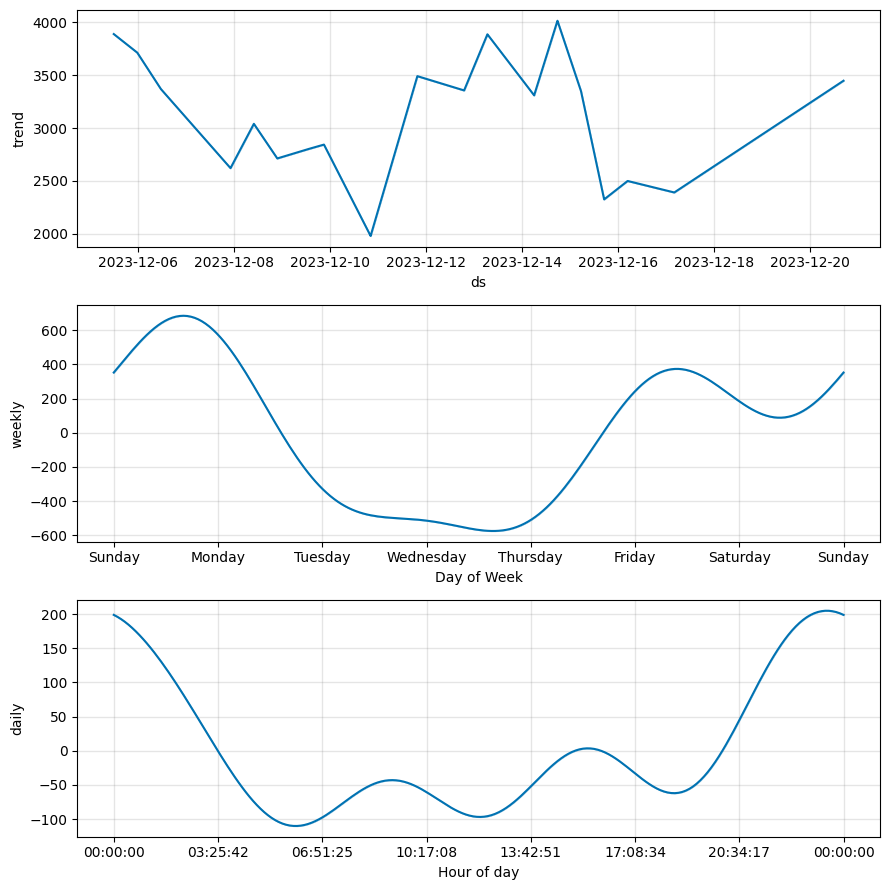

In [ ]:
figure_2 = m.plot_components(forecast)

In [ ]:

plot_plotly(m, forecast)

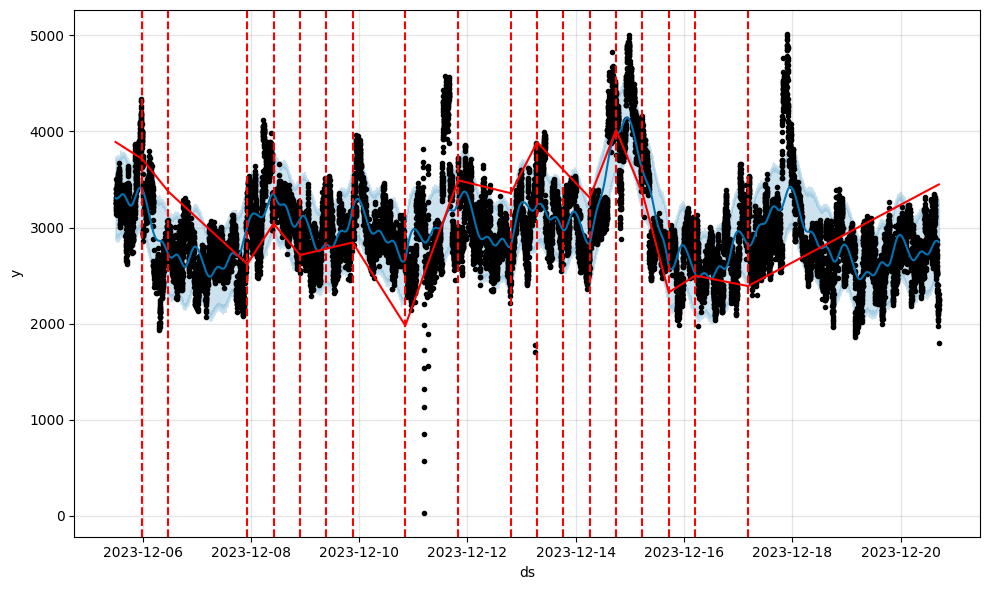

In [ ]:
fig_change_points = add_changepoints_to_plot ( figure_1.gca(), m, forecast)
figure_1

In [ ]:
# error and metrics
perf_mae = mean_absolute_error(merged_df['y'], merged_df['yhat'])
print ("mae ", perf_mae)
perf_mape = mean_absolute_percentage_error(merged_df['y'], merged_df['yhat'])
print("mape " , perf_mape )

mae  247.35239475891814
mape  0.08838066084306039


In [ ]:
merged_df["anomaly"] = merged_df.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)

# Check the number of anomalies
merged_df["anomaly"].value_counts()

0    20144
1     1753
Name: anomaly, dtype: int64

In [ ]:
anomalies_df = merged_df[ merged_df["anomaly"]==1].sort_values(by='ds')
anomalies_df.head(100)

<Axes: xlabel='ds', ylabel='y'>

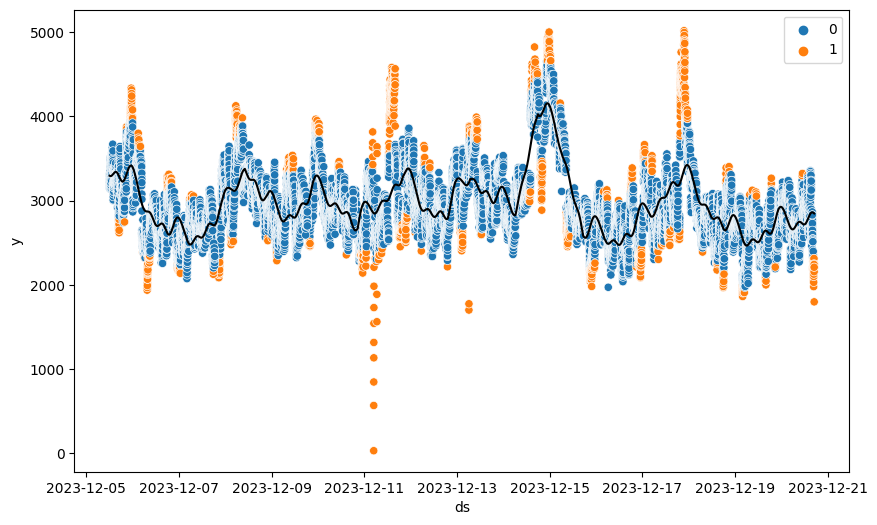

In [ ]:
# Visualize the anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x="ds", y="y", data=merged_df, hue="anomaly")
sns.lineplot(x="ds", y="yhat", data=merged_df, color="black")

In [ ]:
# Calculate residuals (difference between actual and predicted values)
merged_df['residuals'] = merged_df['y'] - merged_df['yhat']

merged_df.info()

# single_merged_df =


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21897 entries, 0 to 21896
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          21897 non-null  datetime64[ns]
 1   y           21897 non-null  float64       
 2   yhat        21897 non-null  float64       
 3   yhat_lower  21897 non-null  float64       
 4   yhat_upper  21897 non-null  float64       
 5   anomaly     21897 non-null  int64         
 6   residuals   21897 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 1.3 MB


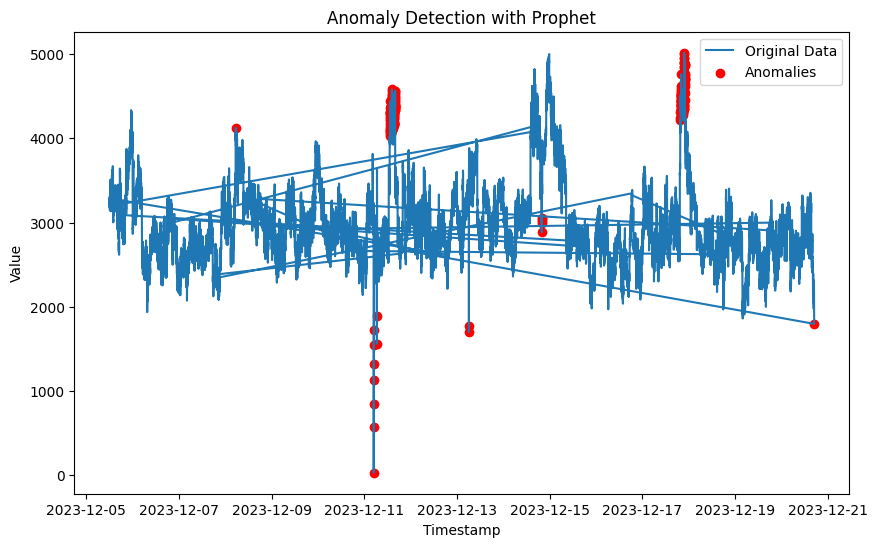

In [ ]:
# Calculate mean and standard deviation of residuals
mean_residual = merged_df['residuals'].mean()
std_residual = merged_df['residuals'].std()

# Set a threshold for anomalies (e.g., 3 standard deviations)
threshold = 3 * std_residual

# Identify anomalies
anomalies = merged_df[np.abs(merged_df['residuals'] - mean_residual) > threshold]

# Plotting the data and anomalies
plt.figure(figsize=(10, 6))
plt.plot(merged_df['ds'], merged_df['y'], label='Original Data')
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Anomaly Detection with Prophet')
plt.show()

In [ ]:
perf_cv = cross_validation(m, initial='6 days', period='2 days', horizon = '1 days')

INFO:prophet:Making 5 forecasts with cutoffs between 2023-12-11 16:59:00 and 2023-12-19 16:59:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmps56yc2au/6ipy6g4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps56yc2au/_q_ldyq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30610', 'data', 'file=/tmp/tmps56yc2au/6ipy6g4b.json', 'init=/tmp/tmps56yc2au/_q_ldyq6.json', 'output', 'file=/tmp/tmps56yc2au/prophet_modelz9cavk8d/prophet_model-20231224054519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:45:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:45:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmps56yc2au/th8p7cml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps56yc2au/8mrfha63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
perf_cv_metrics = performance_metrics( perf_cv)

In [ ]:
perf_cv_metrics.info()

perf_cv_metrics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   horizon   1297 non-null   timedelta64[ns]
 1   mse       1297 non-null   float64        
 2   rmse      1297 non-null   float64        
 3   mae       1297 non-null   float64        
 4   mape      1297 non-null   float64        
 5   mdape     1297 non-null   float64        
 6   smape     1297 non-null   float64        
 7   coverage  1297 non-null   float64        
dtypes: float64(7), timedelta64[ns](1)
memory usage: 81.2 KB


horizon           mse         rmse          mae      mape  \
0    0 days 02:24:00  6.415122e+05   800.944551   585.127781  0.208649   
1    0 days 02:25:00  6.476860e+05   804.789395   588.845356  0.209892   
2    0 days 02:26:00  6.542060e+05   808.830003   592.710012  0.211195   
3    0 days 02:27:00  6.606320e+05   812.792732   596.380771  0.212422   
4    0 days 02:28:00  6.680244e+05   817.327586   601.129154  0.213951   
...              ...           ...          ...          ...       ...   
1292 0 days 23:56:00  1.583828e+07  3979.733049  2929.908862  1.019900   
1293 0 days 23:57:00  1.586298e+07  3982.835589  2933.508288  1.022055   
1294 0 days 23:58:00  1.588369e+07  3985.434922  2937.161350  1.024001   
1295 0 days 23:59:00  1.590590e+07  3988.220051  2940.784563  1.026072   
1296 1 days 00:00:00  1.593126e+07  3991.398706  2945.312971  1.028863   

         mdape     smape  coverage  
0     0.131463  0.197359  0.508333  
1     0.131622  0.198627  0.505556  
2     0.131758  0.199951  0.502778  
3     0.132269  0.201210  0.500000  
4     0.133613  0.202822  0.494444  
...        ...       ...       ...  
1292  0.487276  0.808889  0.400000  
1293  0.489095  0.809907  0.400000  
1294  0.491225  0.810995  0.400000  
1295  0.492018  0.812069  0.400000  
1296  0.493735  0.813535  0.400000  

[1297 rows x 8 columns]

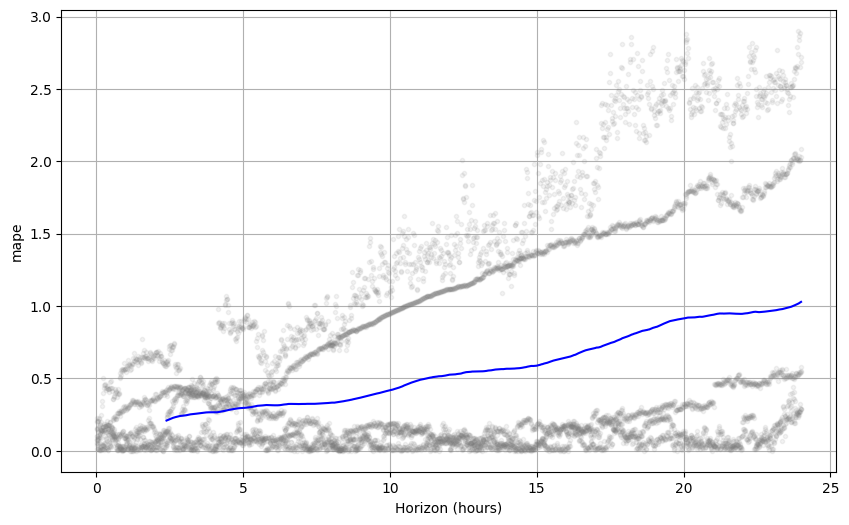

In [ ]:
fig = plot_cross_validation_metric(perf_cv, metric='mape')